### Tensorflow time series forecasting applied to driving cycle data
Reference: https://www.tensorflow.org/tutorials/structured_data/time_series

**TODO**
1. Test for different OUT_STEPS
2. Set the lower limit of the driving cycle to 0: does it need to be stacked as an output layer inside the model or anywhere else?

### OBD Driving Cycle (Majang ~ Hanyang Univ.)

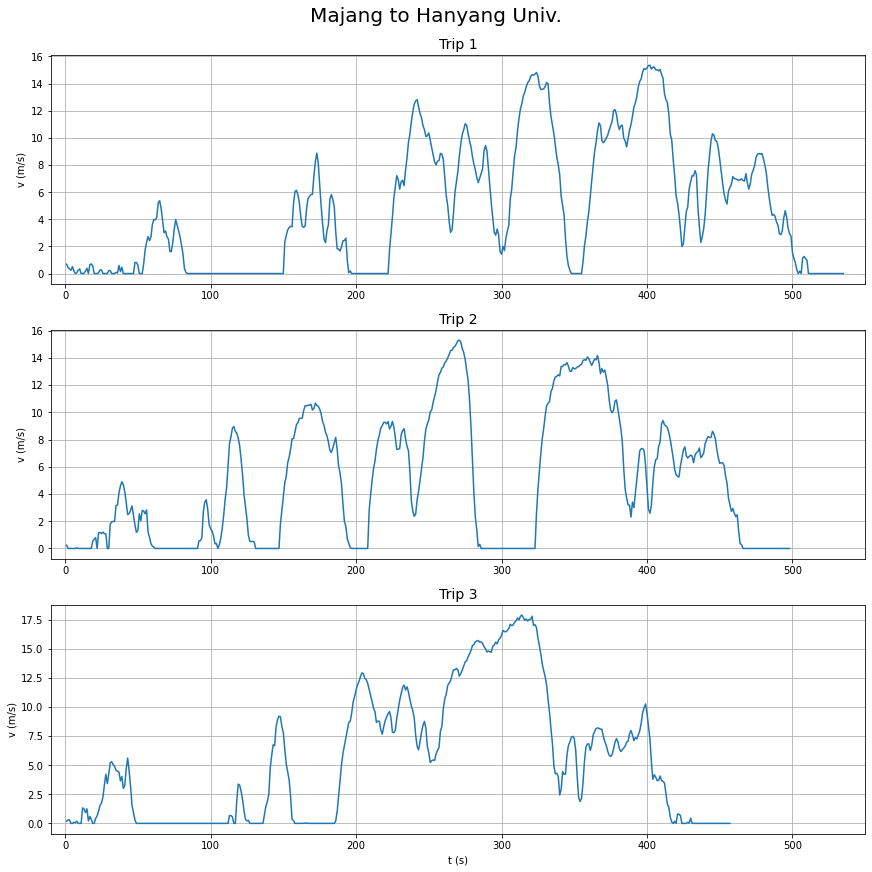

In [305]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import copy
import pathlib

DRIVING_CYCLE = 'obd'

NUM_TRAINING_CYCLES = 2
NUM_TEST_CYCLES = 1
TOTAL_NUM_CYCLES = NUM_TRAINING_CYCLES + NUM_TEST_CYCLES

# Parameters
BATCH_SIZE = 16
EPOCHS = 100

NUM_HIDDEN_LAYERS = 2
NUM_LSTM_UNITS = 16

VAL_SPLIT = 0.1

IN_STEPS = [30, 60]
OUT_STEPS = 30

ROOT_DIR = pathlib.Path("D:\Documents\Project\EV SIMULATION\ml")

# Driving cycle dataset
# df: original data to be referred to later
csv = ['majang_to_hanyang_univ_trip1.csv',
       'majang_to_hanyang_univ_trip2.csv',
       'majang_to_hanyang_univ_trip3.csv']

dfs = [pd.read_csv(ROOT_DIR / "data/obd" / csv[i], names=['t (s)', 'v (m/s)'], index_col='t (s)')
       for i in range(TOTAL_NUM_CYCLES)]

# Concatenate the first and second data
df = pd.concat([dfs[0], dfs[1]], ignore_index=True)

# Val: VAL_SPLIT of (dfs[0] + dfs[1])
n = len(df)
train_df = df[0:int(n * (1 - VAL_SPLIT))]
val_df = df[int(n * (1 - VAL_SPLIT)):]

# Test: dfs[2]
test_df = dfs[2]

# Normalize the data
train_mean = train_df.mean()
train_std = train_df.std()

train_df_norm = (train_df - train_mean) / train_std
val_df_norm = (val_df - train_mean) / train_std
test_df_norm = (test_df - train_mean) / train_std

fig, axs = plt.subplots(TOTAL_NUM_CYCLES, 1,
                        figsize=(12, 4 * TOTAL_NUM_CYCLES),
                        constrained_layout=True)
fig.suptitle("Majang to Hanyang Univ.", fontsize=20)
for i in range(TOTAL_NUM_CYCLES):
    axs[i].plot('v (m/s)', data=dfs[i])
    axs[i].set_title("Trip " + str(i + 1), fontsize=14)
    axs[i].set_ylabel('v (m/s)')
    axs[i].grid(True)
    axs[i].set_xlim(-10, 550)

plt.xlabel('t (s)')
plt.show()

In [306]:
# Class for data windowing
class WindowGenerator():
    # 1. Indexes and offsets
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df_norm,
                 val_df=val_df_norm,
                 test_df=test_df_norm,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]

        # Store example batch of tf.data.Dataset
        self._example = None

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    # 2. Split into inputs/labels
    def split_window(self, features):
        # [batch_size, window_size, features]
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.label_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    # 3. Plot
    def plot(self, model=None, plot_col='v (m/s)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col] # Here we have only one input column.
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n + 1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()
                  
        plt.xlabel('Time [s]')

    # 4. Create tf.data.Dataset
    # Convert pandas.DataFrame to tensorflow.data.Dataset
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=BATCH_SIZE)
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        result = next(iter(self.train))
#         result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

### LSTM Model for Multi-Step Prediction

In [307]:
def build_lstm_model(num_hidden_layers=NUM_HIDDEN_LAYERS, num_lstm_units=NUM_LSTM_UNITS):
    lstm_model = tf.keras.Sequential()

    ret_seq = True
    for i in range(num_hidden_layers):
        # Shape [batch, time, features] => [batch, lstm_units]
        # Adding more `lstm_units` just overfits more quickly.
        if i == num_hidden_layers - 1:
            ret_seq = False
        lstm_model.add(tf.keras.layers.LSTM(num_lstm_units, recurrent_dropout=0.5, return_sequences=ret_seq))

    # Shape => [batch, out_steps * features]
    lstm_model.add(tf.keras.layers.Dense(OUT_STEPS, kernel_initializer=tf.keras.initializers.Zeros()))
    # Set the lower limit value for the velocity to 0. (See TODO at the head.)
    # def custom_layer(x):
    #     return [0 if i < 0 else i for i in x]
    # lstm_model.add(tf.keras.layers.Lambda(lambda x: 0 if x < 0 else x))
    # lstm_model.add(tf.keras.layers.Lambda(custom_layer))
    # Shape => [batch, out_steps, features]
    lstm_model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))
    
    return lstm_model

class MyModel():
    def __init__(self, in_steps, out_steps):
        self.model = build_lstm_model()
        self.in_steps = in_steps
        self.out_steps = out_steps
        self.window = WindowGenerator(input_width=in_steps,
                                      label_width=out_steps,
                                      shift=out_steps)

    def compile(self):
        self.model.compile(loss=tf.losses.MeanSquaredError(),
                           optimizer=tf.optimizers.Adam(),
                           metrics=[tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsoluteError()])

    def fit(self, epochs, patience=2):
#         early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                           patience=patience,
#                                                           mode='min')
        return self.model.fit(self.window.train, epochs=epochs,
                              validation_data=self.window.val)
#                               callbacks=[early_stopping])

    def evaluate(self):
        return self.model.evaluate(self.window.val), self.model.evaluate(self.window.test)

    def plot(self):
        self.window.plot(self.model)
        plt.show()
        
    def save(self, path):
        self.model.save(path)
        
    def reset(self):
        self.model = tf.keras.models.clone_model(self.model)
        
    def predict(self, tf_dataset):
        return self.model.predict(tf_dataset)    

#### Train and save each model & plot results

Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): None> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): None> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause:

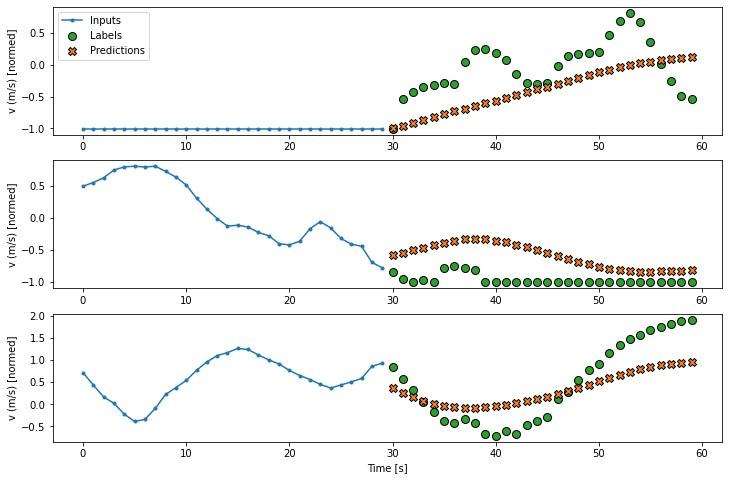

INFO:tensorflow:Assets written to: D:\Documents\Project\EV SIMULATION\ml\models\LSTM\obd\16-100\30-30-16-16\assets
Epoch 1/100
53/53 [==============================] - 4s 76ms/step - loss: 0.9604 - root_mean_squared_error: 0.9800 - mean_absolute_error: 0.8601 - val_loss: 1.6698 - val_root_mean_squared_error: 1.2922 - val_mean_absolute_error: 1.2852
Epoch 2/100
53/53 [==============================] - 4s 70ms/step - loss: 0.8598 - root_mean_squared_error: 0.9273 - mean_absolute_error: 0.7989 - val_loss: 1.9092 - val_root_mean_squared_error: 1.3817 - val_mean_absolute_error: 1.3759
Epoch 3/100
53/53 [==============================] - 4s 72ms/step - loss: 0.8305 - root_mean_squared_error: 0.9113 - mean_absolute_error: 0.7775 - val_loss: 1.6405 - val_root_mean_squared_error: 1.2808 - val_mean_absolute_error: 1.2749
Epoch 4/100
53/53 [==============================] - 4s 70ms/step - loss: 0.8028 - root_mean_squared_error: 0.8960 - mean_absolute_error: 0.7599 - val_loss: 0.6075 - val_root_me

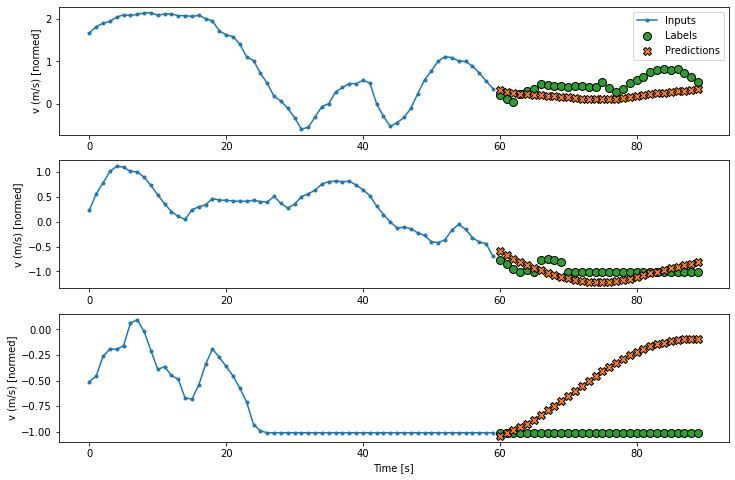

INFO:tensorflow:Assets written to: D:\Documents\Project\EV SIMULATION\ml\models\LSTM\obd\16-100\60-30-16-16\assets


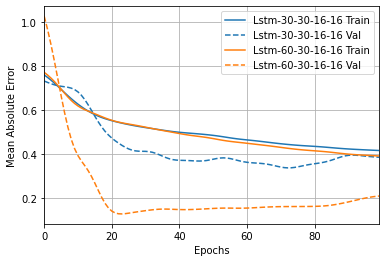

In [308]:
NUM_MODELS = len(IN_STEPS)

lstm_id = ('-' + str(NUM_LSTM_UNITS)) * NUM_HIDDEN_LAYERS
make_key = lambda i: 'LSTM-' + str(i) + '-' + str(OUT_STEPS) + lstm_id
my_models_keys = [make_key(i) for i in IN_STEPS]

my_models = {}
histories = {}
performance = {}
val_performance = {}

for i, key in enumerate(my_models_keys):
    model = MyModel(IN_STEPS[i], OUT_STEPS)
    
    model.compile()
    histories[key] = model.fit(EPOCHS, patience=10)
    val_performance[key], performance[key] = model.evaluate()
    
    model.plot()
    
    dir_id = str(BATCH_SIZE) + "-" + str(EPOCHS)
    model.save(ROOT_DIR / "models/LSTM" / DRIVING_CYCLE / dir_id / key[5:])
    
    # Cache it to access later.
    my_models[key] = model

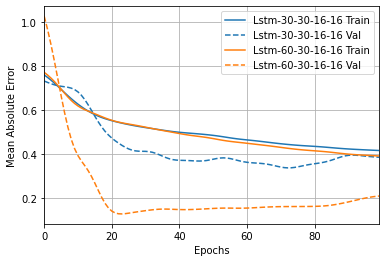

In [310]:
# Plot learning curves of the trainings.
plotter = tfdocs.plots.HistoryPlotter(metric='mean_absolute_error', smoothing_std=10)
plotter.plot(histories)

#### Predict with each model & save the results in csv files

In [309]:
test_data = np.array(test_df_norm, dtype=np.float32)

predictions = {}

for i, key in enumerate(my_models_keys):
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=test_data,
        targets=None,
        sequence_length=IN_STEPS[i],
        sequence_stride=OUT_STEPS,
        shuffle=False,
        batch_size=BATCH_SIZE)

    model = my_models[key]

    prediction = model.predict(ds)
    predictions[key] = (prediction * train_std[0]) + train_mean[0]

##### First confirm everything has been alright so far
</br>

**TODO**
1. Migrate to the method of the MyModel class

In [311]:
def plot(model_name, i_th):
    model = my_models[model_name]
    
    input_start = (i_th - 1) * model.out_steps
    input_end = output_start = (i_th - 1) * model.out_steps + model.in_steps
    output_end = i_th * model.out_steps + model.in_steps
    
    input_indices = np.arange(input_start, input_end)
    label_indices = np.arange(output_start, output_end)
    
    test_data = np.array(test_df, dtype=np.float32)
    
    inputs = test_data[input_start:input_end, 0]
    labels = test_data[output_start:output_end, 0]

    plt.figure(figsize=(12, 3))
    plt.plot(input_indices, inputs,
             label='Inputs', marker='.', zorder=-10)

    plt.scatter(label_indices, labels,
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    plt.scatter(label_indices, predictions[model_name][i_th - 1, :, 0],
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)
    
    plt.legend()

    plt.xlabel('Time [s]')
    plt.ylabel('v (m/s) [normed]')

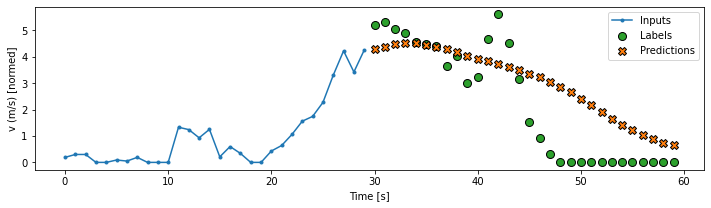

In [312]:
plot('LSTM-30-30-16-16', 1)

##### Visualize the predictions

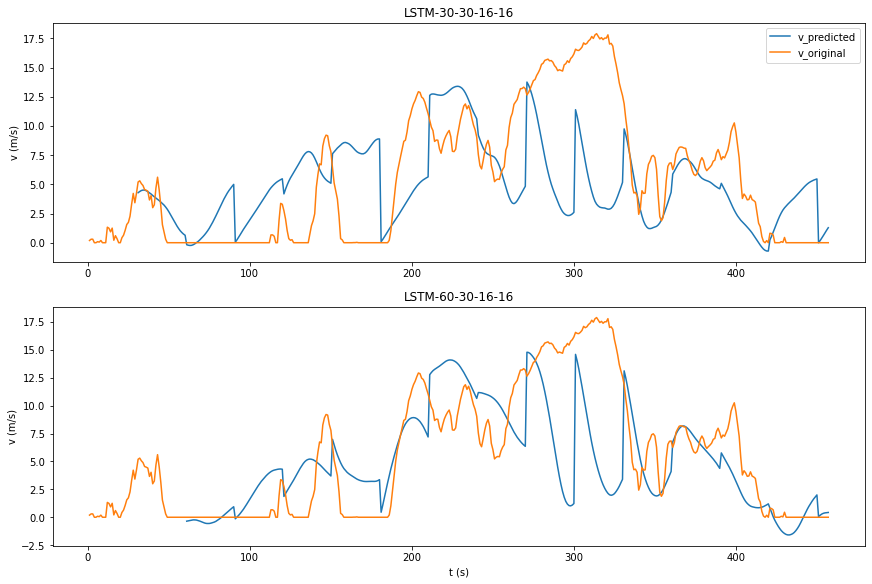

In [313]:
fig, axs = plt.subplots(NUM_MODELS, 1,
                        figsize=(12, 4 * NUM_MODELS),
                        constrained_layout=True)

predictions_df = []
for i, key in enumerate(my_models_keys):
    prediction = predictions[key].flatten()
    
    prediction_df = pd.DataFrame(prediction, columns=['v (m/s)'])
    prediction_df = prediction_df[:test_df.size - IN_STEPS[i]]
    # The beginning index of prediction_df needs to be aligned to test_df.
    prediction_df.set_index(test_df.index[IN_STEPS[i]:], inplace=True)
    
    # To use it when exporting to a csv file below.
    predictions_df.append(prediction_df)
    
    axs[i].plot('v (m/s)', label='v_predicted', data=prediction_df)
    axs[i].plot('v (m/s)', label='v_original', data=test_df)
    axs[i].set_title(key)
    axs[i].set_ylabel('v (m/s)')
    
    if i == 0:
        axs[i].legend()

plt.xlabel('t (s)')
plt.show()

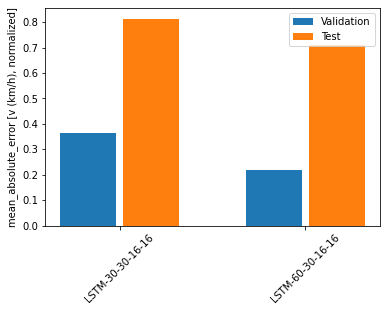

In [314]:
x = np.arange(len(performance))
width = 0.3

metric_index = model.model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [v (km/h), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()

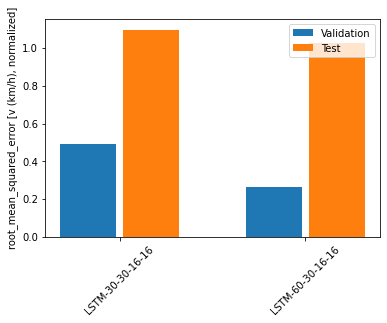

In [315]:
metric_index = model.model.metrics_names.index('root_mean_squared_error')

val_rmse = [v[metric_index] for v in val_performance.values()]
test_rmse = [v[metric_index] for v in performance.values()]

plt.ylabel('root_mean_squared_error [v (km/h), normalized]')
plt.bar(x - 0.17, val_rmse, width, label='Validation')
plt.bar(x + 0.17, test_rmse, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()

##### Export to a csv file

In [80]:
for i, key in enumerate(my_models_keys):
    prediction_df = predictions_df[i]
    
    prediction_df.index.name = 'time'
    prediction_df.columns = ['v']
    
    # Set the lower limit value for the velocity to 0
    # See TODO at the head.
    prediction_df = prediction_df.applymap(lambda x: 0 if x < 0 else x)
    
    csv = key + '.csv'
    prediction_df.to_csv(ROOT_DIR / "data/model_output" / DRIVING_CYCLE / csv)